# ch 8. Transformer

이전 챕터에서 Attention Mechanism을 배웠습니다. 이는 긴 시퀀스에 대해서 효과적인 대응이 가능했지만, 가뜩이나 느린 RNN을 더욱 느리게 만드는 문제가 있었습니다.

Transformer는 이러한 문제점을 해결하기 위해서 등장한 새로운 신경망 아키텍처입니다. 이는 시퀀스 내의 데이터들끼리 서로 Attention을 계산하는 self-attention이라는 기법을 제안했으며, 자연어 처리 뿐만 아니라 거의 모든 분야에서 뛰어난 성능을 내어 현재 AI 분야의 표준으로 자리잡았습니다. 이번 챕터에서는 Transformer의 핵심적인 개념들을 배워보도록 하겠습니다.

## Transformer 아키텍처

transformer 모델은 구글의  "Attention is all you need" 라는 아주 도발적인 제목의 논문에서 제안되었습니다. 이는 기존에 CNN이나 RNN에 의존하지 않는 새로운 모델 아키텍처입니다. 구조는 아래와 같습니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/1.png)

seq2seq 모델과 마찬가지로 encoder와 decoder로 구성되어 있습니다. 트랜스포머 아키텍처의 가장 큰 특징은 다음과 같이 요약할 수 있습니다. 각각이 무엇인지 하나씩 알아보겠습니다.

- self-attention만으로 신경망 모델 구축
- multihead attention을 이용한 병렬처리 극대화
- positional encoding을 이용하여 Recurrent 구조 제거

## Positional Encoding

먼저 transformer가 어떻게 Recurrent 구조 없이, 자연어를 처리할 수 있는지 알아보겠습니다. 자연어 처리에 RNN을 썼던 이유는 문내에서 토큰이 등장하는 순서를 모델에 반영하기 위해서였습니다. Transformer는 positional encoding이라는 개념을 사용하여 이를 대체합니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/2.png)

postional encoding을 직관적으로 이해해보면 토큰이 등장한 위치 정보를 벡터로 표현한 것입니다. 수식으로 나타내면 아래와 같습니다.

$$PE(pos, 2i)=sin(pos/10000^{2i/d_{model}})$$
$$PE(pos, 2i+1)=cos(pos/10000^{2i/d_{model}})$$

여기서 (pos, i)란 토큰에서 추출한 임베딩 벡터들을 모아놓은 행렬에서의 좌표 값을 말합니다. 이 임베딩 행렬에 토큰이 등장한 위치 정보를 나타내는 포지셔널 인코딩 행렬을 더해주어 위치 정보를 반영해줍니다

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/3.png)

토큰의 개수가 50개, 임베딩의 차원 수가 256이라고 가정하고 positional encoding을 시각화해보면 아래와 같습니다.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(max_len, d_model):
    pos_enc = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(d_model):
            if i % 2 == 0:
                pos_enc[pos, i] = np.sin(pos / 10000 ** (i / d_model))
            else:
                pos_enc[pos, i] = np.cos(pos / 10000 ** ((i - 1) / d_model))
    return pos_enc

In [4]:
def plot_positional_encoding(pos_enc):
    plt.figure(figsize=(10, 6))
    plt.imshow(pos_enc, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title("Positional Encoding")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Position")
    plt.show()

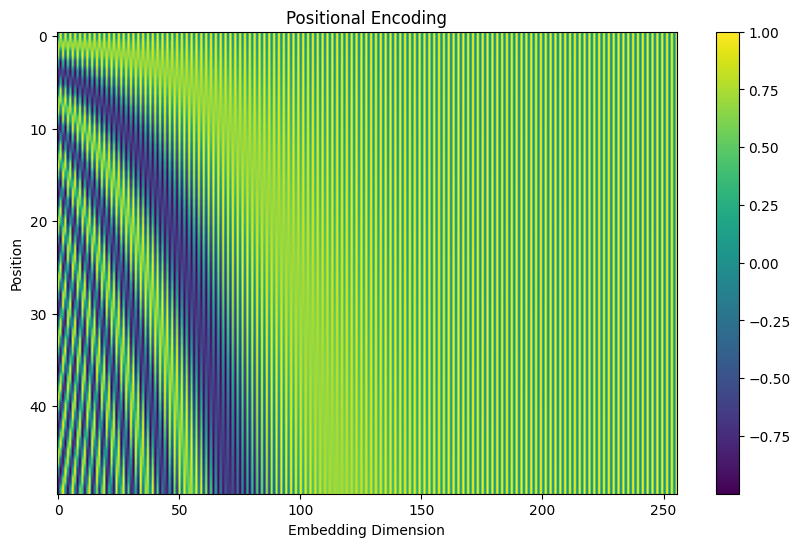

In [5]:
max_len = 50  
d_model = 256 
pos_enc = positional_encoding(max_len, d_model)
plot_positional_encoding(pos_enc)

transformer는 이렇게 토큰이 등장한 순서대로 Recurrent하게 모델을 통과하는 것이 아니라, 임베딩 행렬에 positional encoding 행렬을 더해준 다음, 한번에 모델을 통과시키는 방식으로 학습을 진행합니다. 덕분에 학습 속도를 저해하는 Recurrent 구조를 제거할 수 있었습니다.

## Self Attention

### Attention
self-attention을 이해하기에 앞서서 attention에 대해 먼저 짚어보겠습니다. 이전 챕터에서 Attention은 Query, Key, Value로 Attention Score를 계산한다고 했습니다. 수식과 다이어그램은 아래와 같습니다.

$$Atteion(Q,K,V)=Attention\;Score$$

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/4.png)

Query와 Key 간의 유사도를 계산하여 가중치를 구하고, 이를 Value에 적용하는 것이 Attention 연산이었습니다. 기존 seq2seq 모델에서 Q, K, V는 아래와 같습니다.

- Q: t시점의 decoder hidden state
- K: 모든 시점의 encoder hidden state
- V: 모든 시점의 encoder hidden state

### Self Attention

Transformer 모델에서의 Self-Attention은 Q, K, V가 모두 자기 자신입니다.  "I am a student" 라는 시퀀스가 있다면, 시퀀스 내의 토큰들끼리 서로서로 Attention을 계산한다는 의미로 생각하시면 됩니다.

- Q: 입력 문장의 모든 단어 벡터들
- K: 입력 문장의 모든 단어 벡터들
- V: 입력 문장의 모든 단어 벡터들

문장 내 토큰끼리의 Attention이 왜 중요한지 살펴보겠습니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/5.png)

첫번째 문장과 두번째 문장은 마지막 단어만 각각 "tired", "wide"로 다르고, 나머지 단어는 모두 동일한 문장입니다. 그런데 첫번째 문장에서의 "it"은 문맥상 "animal"을 나타내는 반면, 두번째 문장에서의 "it"은 문맥상 "street"을 가리킵니다.

만약 이 두 문장을 프랑스어로 번역할 경우, 프랑스어에서의 "동물"과 "거리"는 다른 성별을 갖습니다. 즉, "it"이라는 토큰을 정확하게 번역해내기 위해서는 시퀀스 내의 다른 토큰들에 주목할 필요성이 있다는 것을 의미합니다. 이것이 self attention의 개념입니다.

그렇다면 transformer는 이러한 self-attention을 어떻게 구현했는지 살펴보겠습니다. 

### Query, Key, Value

self-attention을 수행하기 위해서는 각 단어 벡터들에 각각 weight를 곱하여 Query, Key, Value 벡터들을 얻어줍니다. 예를들어 d_model이 512, num_heads가 8이라면 Q, K, V 벡터들의 차원은 64가 됩니다.

$$d_{model}=\text{단어 임베딩 차원}$$

$$num_heads=\text{멀티 헤드 어텐션 수}$$

$$\text{Q, K, V의 차원}=d_{model}/\text{num_heads}$$

$$W^{Q,K,V}\text{의 차원}=(d_{model}, d_{model}/\text{num_heads})$$


이를 시퀀스의 모든 토큰들로 확장하여 수행하면 아래와 같이 행렬 연산으로 표현할 수 있습니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/6.png)

### Scaled dot product Attention

이제 Q, K, V 벡터로 scaled dot product attention을 진행합니다. 이는 이전 챕터에서 배웠던 Attention mechanism과 유사합니다. Q와 K의 유사도를 점곱(dot product)로 계산하고, 이를 V에 적용하면 됩니다. Scaled dot product attention은 여기에 유사도 값의 범위를 scaling하는 로직이 추가된 방식입니다. 

$$Attention(Q,K,V)=softmax(\frac{QK^{T}}{\sqrt{d_{k}}})V$$

수식을 살펴보면 먼저 Q 행렬과 K의 전치 행렬을 곱해줍니다. 이는 모든 토큰들의 Q 벡터와 K 벡터를 내적한 값들이 유사도 행렬이 됩니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/8.png)

이렇게 구한 유사도 행렬을 scaling 해준 뒤, softmax를 취해줍니다. 그 다음 V에 곱해주어 Attention Value 행렬을 얻게 됩니다. 이 과정을 scaled dot product attention 이라고 부릅니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/9.png)

이 과정을 간단히 정리하면 아래와 같습니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/10.png)

### Mutltihead Attention
Transformer 모델은 이러한 Self Attention 과정을 각기 다른 웨이트 값을 사용하여 병렬적으로 수행합니다. 이 때 병렬적으로 수행하는 횟수를 결정하는 파라미터가 num_heads입니다. 마치 히드라처럼 여러개의 머리가 각기 다른 시점에서 Attention을 수행한다고 하여 Multi-head attention이라고 부릅니다. 이를 통해 시퀀스 내의 토큰들 간의 상관관계를 더욱 풍부하게 학습할 수 있습니다.

이렇게 얻은 attention value 행렬들은 하나로 concat 해주고 linear layer를 통과시켜 다음 층에 전달합니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/11.png)

논문에서는 이 과정을 아래처럼 표현했습니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/12.png)

## 세 종류의 Multihead Attention

transformer 아키텍처로 돌아가보면 총 3종류의 서로 다른 multi-head attention을 수행합니다. 
![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/13.png)

### Encoder Multihaed Attention

먼저 encoder에 multi-head attention입니다. 이는 input sequence에 대해서 self-attention을 수행합니다. 구조는 앞서 살펴본 기본 multi-head attention과 동일합니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/14.png)

### Masked Multi-head Attention

다음으로 decoder입니다. decoder에서는 먼저 Masked Multihead Attention이라는 층을 거칩니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/15.png)

transformer 모델도 teacher forcing을 사용하기 때문에 decoder가 output sequence를 입력으로 받습니다. 이 때, 자기자신보다 앞에 등장한 토큰들의 attention score만 볼 수 있도록 뒤에 오는 토큰들은 가려주어야 합니다. 그래야만 inference 시점에 앞에 오는 토큰 값들을 보고 이어질 토큰을 예측할 수 있습니다. 이 작업을 self-attention 과정에서 mask를 더해주는 작업으로 구현하며, 이를 병렬적으로 수행하는 것이 masked self attention입니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/16.png)

예를들어 Q와 K의 점곱으로 아래와 같은 유사도 행렬이 나왔다고 가정하겠습니다.
![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/17.png)

In [6]:
similar_matrix = np.array([
    [0.11, 0.00, 0.81, 0.79],
    [0.19, 0.50, 0.30, 0.48],
    [0.53, 0.98, 0.95, 0.14],
    [0.81, 0.86, 0.38, 0.90]
])

여기에 자기 자신보다 뒤에 나오는 토큰들에 대한 유사도 값을 가려주겠습니다. 이를 위해서 먼저 마스크를 생성해보겠습니다. 마스크로 가리고 싶은 곳은 -inf로, 그렇지 않은 곳은 0으로 채워줍니다.

In [7]:
def generate_mask(seq_length):
    mask = np.triu(np.ones((seq_length, seq_length)), k=1)  # Upper triangular matrix
    mask = np.where(mask == 1, float('-inf'), 0)  # Replace 1's with -inf, and 0's remain as 0
    return mask

In [8]:
mask = generate_mask(4)
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

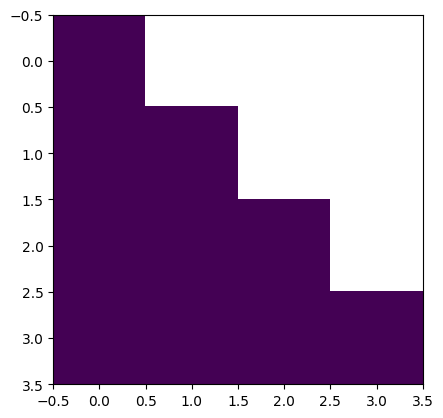

In [9]:
plt.imshow(mask)

마스크를 유사도 행렬에 더해줍니다.

In [10]:
similar_matrix += mask
similar_matrix

array([[0.11, -inf, -inf, -inf],
       [0.19, 0.5 , -inf, -inf],
       [0.53, 0.98, 0.95, -inf],
       [0.81, 0.86, 0.38, 0.9 ]])

여기에 softmax를 취해주면 -inf 값으로 채워진 값들이 0으로 변환됩니다. 이를 V에 적용하여 Attention Value를 구해주는 것이 masked self-attention입니다. 그리고 이를 num_heads만큼 병렬적으로 수행해주는 것이 masked multi-head attention입니다.

In [11]:
import torch

similar_tensor = torch.tensor(similar_matrix)
torch.nn.functional.softmax(similar_tensor, dim=1)

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4231, 0.5769, 0.0000, 0.0000],
        [0.2445, 0.3834, 0.3721, 0.0000],
        [0.2634, 0.2769, 0.1714, 0.2882]], dtype=torch.float64)

### Cross Attention

마지막으로 decoder에서 encoder로부터 전달받은 Attention 값을 K와 V로 사용하고, masked self attention 결과로 얻은 값을 V로 사용하는 multi-head attention 층을 통과합니다. Q, K, V가 동일한 값으로부터 추출된 값이 아니기 때문에 이러한 self-attention을 cross attention이라고도 부릅니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/18.png)

여기까지가 transformer 모델에서 수행하는 3종류의 multi-head self attention이었습니다. 다소 복잡합니다만, decoder 단에서는 마스크를 추가하고, encoder의 attention 값과 decoder의 attention 값을 섞어준다는 것만 기억하고 넘억가겠습니다.

## 그 외의 transformer 구성 요소들

### Feed Forward

linear layer를 한번 통과한 다음 ReLU를 취해주고, 다시 linear layer를 통과시켜주는 층입니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/19.png)

### Residual Connection

Multihead Attention이나 Feed Forward layer를 통과하기 이전의 값을 이후의 값에 더해주는 기법입니다. ResNet에서 처음 제안된 뒤, 여러 모델들에서 채택된 구조로, transformer로 채택하였습니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/20.png)

### Layer Normalization

layer normalization은 텐서의 마지막 차원에 대해서 평균과 분산을 구하여 값들을 정규화하는 방식입니다. 개념만 숙지하고 넘어가겠습니다.


![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/21.png)

## Self Attention Visualization

encoder와 decoder의 self-attetion 과정을 시각화 한 자료입니다. 특히 encoder를 통해서 얻은 attention 정보가 decoder에 어떻게 전달되는지 직관적으로 표현되어 있습니다.

![image](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/transformer/23.gif)

## 정리

이상으로 Transformer 모델에 대해서 알아보았습니다. Transformer는 positional encoding을 이용해서 Recurrent 구조를 제거하였고, self-attention이라는 독창적인 구조를 제안했습니다. 그리고 이를 병렬적으로 수행하는 multi-head attention 개념을 도입했습니다. 그 결과 대량의 텍스트를 효과적으로 학습시킬 수 있었습니다. 

Transformer가 제안한 구조는 이후 자연어 처리 분야의 눈분신 발전을 이끌어 현재의 chatGPT까지 이어집니다. 이를 이미지에 맞게 개량한 vision transformer도 뛰어난 성능을 보여주어 컴퓨터 비전 분야에서도 최신 모델들은 transformer 기반으로 이루어져 있습니다. 사실상 거의 모든 분야에서 사용되는 표준이니 만큼, 가장 핵심적인 개념인 self attention만이라도 확실히 이해하고 넘어갔으면 좋겠습니다.

## Reference

- Attention Is All You Need, https://arxiv.org/abs/1706.03762
- google transformer blog post, https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html
- 딥러닝을 이용한 자연어 처리 입문, https://wikidocs.net/31379